#  Data Wrangling

# Introduction

Goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively.

## The Data

### Enhanced Twitter Archive

I manually downloaded this file by clicking the following link: [twitter_archive_enhanced.csv](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)

### Additional Data via the Twitter API

- Retweet count
- Favorite count (Like) 

This additional data can be gathered by anyone from Twitter's API.

### Image Predictions File

This file (image_predictions.tsv) hosted on Udacity's servers and we downloaded it programmatically using python Requests library on the following (URL of the file: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)


# Project Details

Tasks in this project are as follows:

>Data wrangling, which consists of:
- Gathering data
- Assessing data
- Cleaning data 
- Storing
- Analyzing
- Visualizing

>Reporting on
- 1) your data wrangling efforts 
- 2) your data analyses and visualizations

In [94]:
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
import re
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from functools import reduce

# Gather

In [2]:
# Load csv as a Pandas DataFrame
twitter_archive = pd.read_csv('./Data/twitter_archive_enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
#Collect some information about the dataset
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [4]:
# Use requests library to download tsv file
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('./Data/image_predictions.tsv', 'wb') as file:
    file.write(response.content)
image_predictions = pd.read_csv('./Data/image_predictions.tsv', sep='\t')


In [5]:
#Collect some information about this dataset
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


**Query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file.**


In [7]:
#connecting to the API
CONSUMER_KEY = ""
CONSUMER_SECRET = ""
OAUTH_TOKEN = ""
OAUTH_TOKEN_SECRET = "" 

In [8]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

In [9]:
# List of the error tweets
error_list = []
# List of tweets
df_list = []
# Calculate the time of execution
start = time.time()

# For loop which will add each available tweet json to df_list
for tweet_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended',
                               wait_on_rate_limit = True, wait_on_rate_limit_notify = True)._json 
        favorites = tweet['favorite_count'] # Count of the favorites
        retweets = tweet['retweet_count'] # Count of the retweet
        user_followers = tweet['user']['followers_count'] # Count the followers that user had
        user_favourites = tweet['user']['favourites_count'] # Count the favorites that user had
        date_time = tweet['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)

888202515573088257 _ [{'message': 'No status found with that ID.', 'code': 144}]
873697596434513921 _ [{'message': 'No status found with that ID.', 'code': 144}]
869988702071779329 _ [{'message': 'No status found with that ID.', 'code': 144}]
866816280283807744 _ [{'message': 'No status found with that ID.', 'code': 144}]
861769973181624320 _ [{'message': 'No status found with that ID.', 'code': 144}]
845459076796616705 _ [{'message': 'No status found with that ID.', 'code': 144}]
842892208864923648 _ [{'message': 'No status found with that ID.', 'code': 144}]
837012587749474308 _ [{'message': 'No status found with that ID.', 'code': 144}]
827228250799742977 _ [{'message': 'No status found with that ID.', 'code': 144}]
802247111496568832 _ [{'message': 'No status found with that ID.', 'code': 144}]
775096608509886464 _ [{'message': 'No status found with that ID.', 'code': 144}]


Rate limit reached. Sleeping for: 330


714141408463036416 _ Failed to send request: EOF occurred in violation of protocol (_ssl.c:719)
3023.67219209671


In [14]:
# Create DataFrames from list of dictionaries
json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'user_favourites', 'date_time'])
# Save the dataFrame in file
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [15]:
# Read the saved tweet_json.txt file into a dataframe
tweet_data = pd.read_csv('./Data/tweet_json.txt', encoding = 'utf-8')
tweet_data

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,38952,8636,6629272,132918,2017-08-01 16:23:56
1,892177421306343426,33352,6343,6629272,132918,2017-08-01 00:17:27
2,891815181378084864,25127,4209,6629272,132918,2017-07-31 00:18:03
3,891689557279858688,42300,8755,6629272,132918,2017-07-30 15:58:51
4,891327558926688256,40458,9517,6629272,132918,2017-07-29 16:00:24
...,...,...,...,...,...,...
2339,666049248165822465,109,40,6629803,132918,2015-11-16 00:24:50
2340,666044226329800704,301,141,6629803,132918,2015-11-16 00:04:52
2341,666033412701032449,125,44,6629803,132918,2015-11-15 23:21:54
2342,666029285002620928,131,47,6629803,132918,2015-11-15 23:05:30


In [16]:
#Collect some information about this dataset
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2344 non-null   int64 
 1   favorites        2344 non-null   int64 
 2   retweets         2344 non-null   int64 
 3   user_followers   2344 non-null   int64 
 4   user_favourites  2344 non-null   int64 
 5   date_time        2344 non-null   object
dtypes: int64(5), object(1)
memory usage: 110.0+ KB


## Assessing

In [17]:
# Load some random examples
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1553,688908934925697024,NaN,NaN,2016-01-18 02:21:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Clarence. He does parkour. 8/10 very tale...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688908934...,8,10,Clarence,None,None,None,None
1300,707693576495472641,NaN,NaN,2016-03-09 22:24:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jiminus. He's in a tub for some reason...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707693576...,7,10,Jiminus,None,None,None,None
2160,669567591774625800,NaN,NaN,2015-11-25 17:25:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Kollin. He's a Parakeetian Badminton from...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669567591...,9,10,Kollin,None,None,None,None
521,809920764300447744,NaN,NaN,2016-12-17 00:38:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Please only send in dogs. We only rate dogs, n...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/809920764...,10,10,None,None,None,None,None
1989,672828477930868736,NaN,NaN,2015-12-04 17:23:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's a Timbuk Slytherin. Eats h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672828477...,9,10,Jerry,None,None,None,None
827,769212283578875904,NaN,NaN,2016-08-26 16:37:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is DonDon. He's way up but doesn't feel b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/769212283...,12,10,DonDon,None,None,None,None
903,758405701903519748,NaN,NaN,2016-07-27 20:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Odie. He falls asleep wherever he want...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758405701...,10,10,Odie,None,None,None,None
1184,718631497683582976,NaN,NaN,2016-04-09 02:47:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We normally don't rate marshmallows but this o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718631497...,10,10,None,None,None,None,None
2029,671855973984772097,NaN,NaN,2015-12-02 00:58:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Remarkable dog here. Walks on back legs really...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671855973...,8,10,None,None,None,None,None
1814,676617503762681856,NaN,NaN,2015-12-15 04:19:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I promise this wasn't meant to be a cuteness o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676617503...,13,10,None,None,None,pupper,None


In [18]:
# Assessing the data programmaticaly
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [19]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [20]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [21]:
twitter_archive['name'].value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
          ... 
Marq         1
Tom          1
Mason        1
Shooter      1
Jazzy        1
Name: name, Length: 957, dtype: int64

In [22]:
# View descriptive statistics of twitter_archive
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [23]:
#Take a look at image_predictions dataframe 
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [24]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
image_predictions['jpg_url'].value_counts()

https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg                                            2
https://pbs.twimg.com/media/Cbs3DOAXIAAp3Bd.jpg                                            2
https://pbs.twimg.com/media/CrXhIqBW8AA6Bse.jpg                                            2
https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg                                            2
https://pbs.twimg.com/media/CvoBPWRWgAA4het.jpg                                            2
                                                                                          ..
https://pbs.twimg.com/ext_tw_video_thumb/751250895690731520/pu/img/eziHbU1KbgZg-ijN.jpg    1
https://pbs.twimg.com/media/CZ724fDUYAAytS-.jpg                                            1
https://pbs.twimg.com/media/CVVIjGbWwAAxkN0.jpg                                            1
https://pbs.twimg.com/media/CZHyrvOXEAEin-A.jpg                                            1
https://pbs.twimg.com/media/CVLy3zFWoAA93qJ.jpg                       

In [26]:
image_predictions[image_predictions['jpg_url'] == 'https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.22577,True,German_short-haired_pointer,0.175219,True


In [32]:
#check 'p1' values
image_predictions.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
terrapin                1
sunglasses              1
silky_terrier           1
grille                  1
alp                     1
Name: p1, Length: 378, dtype: int64

In [33]:
#check 'p2' values
image_predictions.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
cannon                  1
police_van              1
waffle_iron             1
armadillo               1
water_bottle            1
Name: p2, Length: 405, dtype: int64

In [34]:
#check 'p3' values
image_predictions.p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
croquet_ball           1
sunglass               1
shower_cap             1
mosquito_net           1
soap_dispenser         1
Name: p3, Length: 408, dtype: int64

In [27]:
# Check number of entries for each source
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [28]:
#See rating that don't follow pattern
twitter_archive[twitter_archive['rating_numerator'] > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [30]:
#Fake names
twitter_archive[twitter_archive['name'].apply(len) < 3]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
393,825876512159186944,NaN,NaN,2017-01-30 01:21:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mo. No one will push him around in the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825876512...,11,10,Mo,None,None,None,None
446,819015337530290176,NaN,NaN,2017-01-11 02:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He was a very good ...,8.190048e+17,4.196984e+09,2017-01-11 02:15:36 +0000,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
449,819004803107983360,NaN,NaN,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
553,804026241225523202,NaN,NaN,2016-11-30 18:16:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's going to make me cry. 13/10 p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804026241...,13,10,Bo,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None


In [31]:
#Tweets from the account 
twitter_archive[twitter_archive['retweeted_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


## Quality

**twitter_archive dataset**
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be integers/strings rather than float.
- retweeted_status_timestamp, timestamp should be datetime instead of object (string).
- The numerator and denominator columns have invalid values.
- In several columns null objects are non-null (None to NaN).
- Name column have invalid names i.e 'None', 'a', 'an', 'the', 'by' and less than 3 characters.
- We only want original ratings (no retweets) that have images.
- Sources difficult to read.

**image_predictions dataset**
- Missing values from images dataset (2075 rows instead of 2356)
- Some tweet_ids have the same jpg_url
- Some tweets are have 2 different tweet_id one redirect to the other (Dataset contains retweets)
- Columns (p1, p2, p3) have Capital litters must change to lower case to make search easier

**tweet_data dataset**

- This tweet_id (666020888022790149) duplicated 8 times


## Tidiness

**twitter_archive dataset**
- Dog "stage" variable in four columns: doggo, floofer, pupper, puppo
- Join 'tweet_info' and 'image_predictions' to 'twitter_archive'

**image_predictions dataset**
- No need to all the informations in the dataset, (tweet_id and jpg_url what matters)

## Cleaning
Cleaning our data is the third step in data wrangling. Fix the quality and tidiness issues.

In [60]:
#copy dataframes
tweet_data_clean = tweet_data.copy()
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean= image_predictions.copy()

### Tidiness

#### Add tweet_info and image_predictions to twitter_archive table.

**Code**

In [61]:
# Merge the twitter_archive_clean, tweet_data_clean, and image_predictions_clean on 'tweet_id'
datasets = [twitter_archive_clean, tweet_data_clean, image_predictions_clean]
twitter_archive_clean = reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), datasets)

**Test**

In [62]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2067
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2068 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2068 non-null   object 
 4   source                      2068 non-null   object 
 5   text                        2068 non-null   object 
 6   retweeted_status_id         75 non-null     float64
 7   retweeted_status_user_id    75 non-null     float64
 8   retweeted_status_timestamp  75 non-null     object 
 9   expanded_urls               2068 non-null   object 
 10  rating_numerator            2068 non-null   int64  
 11  rating_denominator          2068 non-null   int64  
 12  name                        2068 non-null   object 
 13  doggo                       2068 

####  combine the 'doggo', 'floofer', 'pupper' and 'puppo' columns into one column 'dog_stage'.

**Code**

In [63]:
# Select the columns to combine and to remain
combined_columns = ['doggo', 'floofer', 'pupper', 'puppo']
stay_columns = [x for x in twitter_archive_clean.columns.tolist() if x not in combined_columns]


# combine the the columns into values
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars = stay_columns, value_vars = combined_columns, 
                         var_name = 'stages', value_name = 'dog_stage')
# Delete column 'stages'
twitter_archive_clean = twitter_archive_clean.drop('stages', 1)

**Test**

In [64]:
print(twitter_archive_clean.dog_stage.value_counts())
print(len(twitter_archive_clean))

None       7938
pupper      222
doggo        80
puppo        24
floofer       8
Name: dog_stage, dtype: int64
8272


#### Clean rows and columns that we will not need

**Code**

In [65]:
# Delete the null retweets
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean.retweeted_status_id)]

# Delete duplicated tweet_id
twitter_archive_clean = twitter_archive_clean.drop_duplicates()

# Delete tweets with no pictures
twitter_archive_clean = twitter_archive_clean.dropna(subset = ['jpg_url'])

In [66]:
#check
len(twitter_archive_clean)

2310

In [67]:
# Delete columns related to retweet we don't need anymore
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_id', 1)
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_user_id', 1)
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_timestamp', 1)

# Delete column date_time we imported from the API, it has the same values as timestamp column
twitter_archive_clean = twitter_archive_clean.drop('date_time', 1)

In [68]:
#check
list(twitter_archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'favorites',
 'retweets',
 'user_followers',
 'user_favourites',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_stage']

In [69]:
#Delete dog_stage duplicates
twitter_archive_clean = twitter_archive_clean.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

**Test**

In [70]:
print(twitter_archive_clean.dog_stage.value_counts())
print(len(twitter_archive_clean))

None       1687
pupper      212
doggo        63
puppo        23
floofer       8
Name: dog_stage, dtype: int64
1993


### Quality

#### Fix rating numerator and denominators that are not actually ratings

**Code**

In [71]:
# View all occurences where there are more than one #/# in 'text' column
text_ratings_to_fix = twitter_archive_clean[twitter_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text

text_ratings_to_fix

C:\Users\lenovo-pc\anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


1400    This is Darrel. He just robbed a 7/11 and is i...
1622    Two gorgeous dogs here. Little waddling dog is...
1522    Meet Tassy &amp; Bee. Tassy is pretty chill, b...
1556    These two pups just met and have instantly bon...
1229    Meet Oliviér. He takes killer selfies. Has a d...
1224    This may be the greatest video I've ever been ...
1134    This is Socks. That water pup w the super legs...
1264    When bae says they can't go out but you see th...
1290    Meet Fynn &amp; Taco. Fynn is an all-powerful ...
1279    This is Eriq. His friend just reminded him of ...
1976    This is Kial. Kial is either wearing a cape, w...
1985    Two dogs in this one. Both are rare Jujitsu Py...
1892    Here we have Pancho and Peaches. Pancho is a C...
1929    This is Spark. He's nervous. Other dog hasn't ...
2018    These are Peruvian Feldspars. Their names are ...
2047    This is an Albanian 3 1/2 legged  Episcopalian...
1727    10/10 for dog. 7/10 for cat. 12/10 for human. ...
1829    Meet H

In [72]:
for entry in text_ratings_to_fix:
    mask = twitter_archive_clean.text == entry
    column_name1 = 'rating_numerator'
    column_name2 = 'rating_denominator'
    twitter_archive_clean.loc[mask, column_name1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", entry)
    twitter_archive_clean.loc[mask, column_name2] = 10

**Test**

In [73]:
twitter_archive_clean[twitter_archive_clean.text.isin(text_ratings_to_fix)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1400,682962037429899265,NaN,NaN,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,10,10,Darrel,...,dingo,0.278600,False,Chihuahua,0.155207,True,loupe,0.153598,False,None
1622,674646392044941312,NaN,NaN,2015-12-09 17:46:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Two gorgeous dogs here. Little waddling dog is...,https://twitter.com/dog_rates/status/674646392...,8,10,None,...,flat-coated_retriever,0.837448,True,groenendael,0.086166,True,Labrador_retriever,0.016052,True,None
1522,677314812125323265,NaN,NaN,2015-12-17 02:30:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Tassy &amp; Bee. Tassy is pretty chill, b...",https://twitter.com/dog_rates/status/677314812...,11,10,Tassy,...,Blenheim_spaniel,0.924127,True,Japanese_spaniel,0.054790,True,Chihuahua,0.008204,True,None
1556,676191832485810177,NaN,NaN,2015-12-14 00:07:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These two pups just met and have instantly bon...,https://twitter.com/dog_rates/status/676191832...,7,10,None,...,Chihuahua,0.376741,True,Italian_greyhound,0.173114,True,muzzle,0.071485,False,None
1229,694352839993344000,NaN,NaN,2016-02-02 02:53:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Oliviér. He takes killer selfies. Has a d...,https://twitter.com/dog_rates/status/694352839...,5,10,Oliviér,...,Australian_terrier,0.407886,True,Yorkshire_terrier,0.328173,True,silky_terrier,0.108404,True,None
1224,695064344191721472,NaN,NaN,2016-02-04 02:00:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This may be the greatest video I've ever been ...,https://twitter.com/dog_rates/status/695064344...,13,10,None,...,seat_belt,0.522211,False,sunglasses,0.077552,False,ice_lolly,0.051774,False,None
1134,703356393781329922,NaN,NaN,2016-02-26 23:10:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Socks. That water pup w the super legs...,https://twitter.com/dog_rates/status/703356393...,2,10,Socks,...,Border_collie,0.894842,True,collie,0.097364,True,English_springer,0.003037,True,None
1264,691483041324204033,NaN,NaN,2016-01-25 04:49:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When bae says they can't go out but you see th...,https://twitter.com/dog_rates/status/691483041...,10,10,None,...,bloodhound,0.886232,True,black-and-tan_coonhound,0.077420,True,Gordon_setter,0.009826,True,None
1290,689835978131935233,NaN,NaN,2016-01-20 15:44:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Fynn &amp; Taco. Fynn is an all-powerful ...,https://twitter.com/dog_rates/status/689835978...,10,10,Fynn,...,collie,0.600186,True,Shetland_sheepdog,0.298939,True,borzoi,0.022616,True,None
1279,690400367696297985,NaN,NaN,2016-01-22 05:07:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Eriq. His friend just reminded him of ...,https://twitter.com/dog_rates/status/690400367...,6,10,Eriq,...,Pembroke,0.426459,True,papillon,0.317368,True,Shetland_sheepdog,0.077616,True,None


#### Fix rating numerator that have decimals.

**Code**

In [74]:
# View tweets with decimals in rating in 'text' column
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\lenovo-pc\anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1446,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,None,...,kuvasz,0.438627,True,Samoyed,0.111622,True,Great_Pyrenees,0.064061,True,None
553,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,...,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True,None
40,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,...,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,None
4745,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,...,clumber,0.946718,True,cocker_spaniel,0.015950,True,Lhasa,0.006519,True,pupper


In [75]:
# Set correct numerators for specific tweets
twitter_archive_clean.loc[(twitter_archive_clean['tweet_id'] == 883482846933004288) & (twitter_archive_clean['rating_numerator'] == 5), ['rating_numerator']] = 13.5
twitter_archive_clean.loc[(twitter_archive_clean['tweet_id'] == 786709082849828864) & (twitter_archive_clean['rating_numerator'] == 75), ['rating_numerator']] = 9.75
twitter_archive_clean.loc[(twitter_archive_clean['tweet_id'] == 778027034220126208) & (twitter_archive_clean['rating_numerator'] == 27), ['rating_numerator']] = 11.27
twitter_archive_clean.loc[(twitter_archive_clean['tweet_id'] == 680494726643068929) & (twitter_archive_clean['rating_numerator'] == 26), ['rating_numerator']] = 11.26

**Test**

In [76]:
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\lenovo-pc\anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1446,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10,None,...,kuvasz,0.438627,True,Samoyed,0.111622,True,Great_Pyrenees,0.064061,True,None
553,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,...,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True,None
40,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.5,10,Bella,...,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,None
4745,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10,Sophie,...,clumber,0.946718,True,cocker_spaniel,0.015950,True,Lhasa,0.006519,True,pupper


#### Get Dogs gender column from text column

**Code**

In [77]:
# Loop on all the texts and check if it has one of pronouns of male or female
# and append the result in a list

male = ['He', 'he', 'him', 'his', "he's", 'himself', 'male']
female = ['She', 'she', 'her', 'hers', 'herself', "she's", 'female']

dog_gender = []

for text in twitter_archive_clean['text']:
    # Male
    if any(map(lambda v:v in male, text.split())):
        dog_gender.append('male')
    # Female
    elif any(map(lambda v:v in female, text.split())):
        dog_gender.append('female')
    # If not specified
    else:
        dog_gender.append('NaN')

# Test
len(dog_gender)

# Save the result in a new column 'dog_name'
twitter_archive_clean['dog_gender'] = dog_gender

**Test**

In [78]:
print("dog_gender count \n", twitter_archive_clean.dog_gender.value_counts())

dog_gender count 
 NaN       1131
male       636
female     226
Name: dog_gender, dtype: int64


#### Convert the null values to None type

**Code**

In [80]:
twitter_archive_clean.loc[twitter_archive_clean['dog_gender'] == 'NaN', 'dog_gender'] = None
twitter_archive_clean.loc[twitter_archive_clean['rating_numerator'] == 'NaN', 'rating_numerator'] = 0

**Test**

In [81]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 7089
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1993 non-null   int64  
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              1993 non-null   object 
 4   source                 1993 non-null   object 
 5   text                   1993 non-null   object 
 6   expanded_urls          1993 non-null   object 
 7   rating_numerator       1993 non-null   object 
 8   rating_denominator     1993 non-null   int64  
 9   name                   1993 non-null   object 
 10  favorites              1993 non-null   int64  
 11  retweets               1993 non-null   int64  
 12  user_followers         1993 non-null   int64  
 13  user_favourites        1993 non-null   int64  
 14  jpg_url                1993 non-null   object 
 15  img_

#### Change datatypes .

**Code**

In [82]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean.timestamp)
twitter_archive_clean['source'] = twitter_archive_clean['source'].astype('category')
twitter_archive_clean['favorites'] = twitter_archive_clean['favorites'].astype(int)
twitter_archive_clean['retweets'] = twitter_archive_clean['retweets'].astype(int)
twitter_archive_clean['user_followers'] = twitter_archive_clean['user_followers'].astype(int)
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].astype('category')
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(float)
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype(float)
twitter_archive_clean['dog_gender'] = twitter_archive_clean['dog_gender'].astype('category')

**Test**

In [83]:
twitter_archive_clean.dtypes

tweet_id                              object
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                datetime64[ns, UTC]
source                              category
text                                  object
expanded_urls                         object
rating_numerator                     float64
rating_denominator                   float64
name                                  object
favorites                              int32
retweets                               int32
user_followers                         int32
user_favourites                        int64
jpg_url                               object
img_num                                int64
p1                                    object
p1_conf                              float64
p1_dog                                  bool
p2                                    object
p2_conf                              float64
p2_dog                                  bool
p3        

#### Change to lower case

**Code**

In [88]:
# make all string lower case 

def toLower(colName):
    twitter_archive_clean[colName] = twitter_archive_clean[colName].str.lower()

toLower('p1')
toLower('p2')
toLower('p3')
toLower('text')
toLower('name')

**Test**

In [89]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,dog_gender
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is phineas. he's a mystical boy. only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,phineas,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None,NaN
1461,679877062409191424,NaN,NaN,2015-12-24 04:11:37+00:00,"<a href=""http://twitter.com/download/iphone"" r...",meet penelope. she's a bacon frise. total babe...,https://twitter.com/dog_rates/status/679877062...,5.0,10.0,penelope,...,0.809466,False,hay,0.060178,False,lumbermill,0.016483,False,None,NaN
1460,680055455951884288,NaN,NaN,2015-12-24 16:00:30+00:00,"<a href=""https://about.twitter.com/products/tw...","meet sammy. at first i was like ""that's a snow...",https://twitter.com/dog_rates/status/680055455...,10.0,10.0,sammy,...,0.995466,True,great_pyrenees,0.001834,True,pomeranian,0.000667,True,None,male
1459,680070545539371008,NaN,NaN,2015-12-24 17:00:27+00:00,"<a href=""https://about.twitter.com/products/tw...",say hello to emmie. she's trapped in an orname...,https://twitter.com/dog_rates/status/680070545...,9.0,10.0,emmie,...,0.127701,False,shih-tzu,0.121811,True,bubble,0.117820,False,None,NaN
1458,680085611152338944,NaN,NaN,2015-12-24 18:00:19+00:00,"<a href=""https://about.twitter.com/products/tw...",this is by far the most coordinated series of ...,https://twitter.com/dog_rates/status/680085611...,12.0,10.0,by,...,0.778113,False,apron,0.095023,False,wallet,0.049326,False,None,NaN


### Store

In [90]:
# Save clean DataFrame to csv file
twitter_archive_clean.drop(twitter_archive_clean.columns[twitter_archive_clean.columns.str.contains('Unnamed',case = False)],axis = 1)
twitter_archive_clean.to_csv('./Data/twitter_archive_master.csv', encoding = 'utf-8', index=False)

In [91]:
#check
twitter_archive_clean = pd.read_csv('./Data/twitter_archive_master.csv')
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1993 non-null   int64  
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              1993 non-null   object 
 4   source                 1993 non-null   object 
 5   text                   1993 non-null   object 
 6   expanded_urls          1993 non-null   object 
 7   rating_numerator       1993 non-null   float64
 8   rating_denominator     1993 non-null   float64
 9   name                   1993 non-null   object 
 10  favorites              1993 non-null   int64  
 11  retweets               1993 non-null   int64  
 12  user_followers         1993 non-null   int64  
 13  user_favourites        1993 non-null   int64  
 14  jpg_url                1993 non-null   object 
 15  img_

### Analyze and Visualize

C:\Users\lenovo-pc\anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


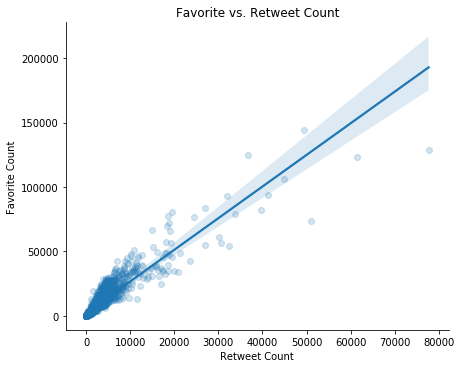

In [96]:
# Plot scatterplot of retweet vs favorite count
sns.lmplot(x="retweets", 
           y="favorites", 
           data=twitter_archive_clean,
           size = 5,
           aspect=1.3,
           scatter_kws={'alpha':1/5})
plt.title('Favorite vs. Retweet Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

>We can see that favourites is larger than retweet four times per tweet, highest retweet count is about 80000 and favourites about 150000

(-1.288268191449591,
 1.2310305760057396,
 -1.2401381220397572,
 1.2110819987279693)

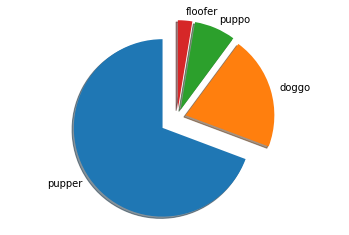

In [97]:
# Plot the data partitioned by dog stage
dog_stage_count = list(twitter_archive_clean[twitter_archive_clean['dog_stage'] != 'None']['dog_stage'].value_counts())[0:4]
dog_stages = twitter_archive_clean[twitter_archive_clean['dog_stage'] != 'None']['dog_stage'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(dog_stage_count, explode = explode, labels = dog_stages, shadow = True, startangle = 90)
ax1.axis('equal')

In [99]:
twitter_archive_clean[twitter_archive_clean['dog_stage'] != 'None'].groupby('dog_stage')['rating_numerator'].mean()

dog_stage
doggo      11.888889
floofer    11.875000
pupper     10.638066
puppo      12.043478
Name: rating_numerator, dtype: float64

>Pupper is the most owned dog, but it has the lowest mean rating

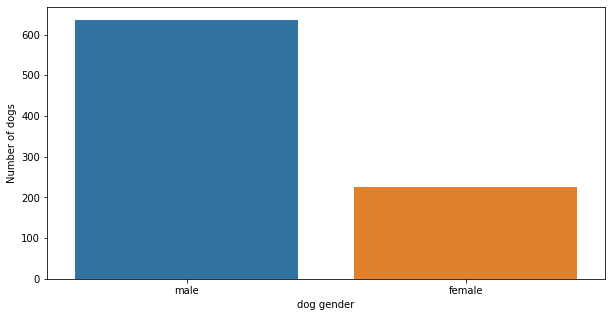

In [101]:
# bar chart
plt.figure(figsize = [10, 5])

graph = sns.countplot(data = twitter_archive_clean, x = "dog_gender", order = twitter_archive_clean.dog_gender.value_counts().index);
graph.set_xlabel('dog gender');
graph.set_ylabel('Number of dogs');

>Number of male is more than female twice